Code has been created by scrapping different kernels and internet forums. 

This got a leader board score of 0.129

Image preprocessing - I have combined the 4 images into 1 image and saved into into a different folder.

Borrows code for combining images from Kernel by Alex V B - https://www.kaggle.com/alexpcli/playing-with-the-images-of-the-protein-atlas

To do 
1) Add LR find and fit_one_cycle
2) Try progressive enlargement from 128 to 512 to improve the accuracy (memory could be a problem, can decrease batch size)
3) Add external data

In [ ]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from fastai import *
from fastai.vision import *
from fastai.vision.image import *

In [5]:
path3 = Config.data_path()/'protien_atlas'
path3

PosixPath('/home/jupyter/.fastai/data/protien_atlas')

In [6]:
path4 = Config.data_path()/'protien_atlas/test'
path4

PosixPath('/home/jupyter/.fastai/data/protien_atlas/test')

In [7]:
df = pd.read_csv(path3/'train.csv')
df.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [8]:
tfms = get_transforms(flip_vert=True, max_lighting=0.2, max_zoom=1.05, max_warp=0.)
#Planning to try the following tfms, not sure it will make much changes 
#tfms2 =get_transforms(flip_vert=True, max_rotate=30., max_zoom=1, max_lighting=0.05, max_warp=0.)

In [9]:
np.random.seed(42)
src = (ImageItemList.from_csv('/home/jupyter/.fastai/data', 'train.csv', folder='protien_atlas', suffix='.png')
       .random_split_by_pct(0.2)
       .label_from_df(sep=' ',  classes=[str(i) for i in range(28)]))

In [10]:
test_ids = list(sorted({fname.split('_')[0] for fname in os.listdir(path4)}))

In [12]:
test_fnames = [path4/test_id for test_id in test_ids]

In [13]:
test_fnames[:5]

[PosixPath('/home/jupyter/.fastai/data/protien_atlas/test/00008af0-bad0-11e8-b2b8-ac1f6b6435d0.png'),
 PosixPath('/home/jupyter/.fastai/data/protien_atlas/test/0000a892-bacf-11e8-b2b8-ac1f6b6435d0.png'),
 PosixPath('/home/jupyter/.fastai/data/protien_atlas/test/0006faa6-bac7-11e8-b2b7-ac1f6b6435d0.png'),
 PosixPath('/home/jupyter/.fastai/data/protien_atlas/test/0008baca-bad7-11e8-b2b9-ac1f6b6435d0.png'),
 PosixPath('/home/jupyter/.fastai/data/protien_atlas/test/000cce7e-bad4-11e8-b2b8-ac1f6b6435d0.png')]

In [14]:
src.add_test(test_fnames, label='0');

In [15]:
data = (src.transform(tfms, size=128)
        .databunch(num_workers=0).normalize(imagenet_stats))

In [16]:
print('Train size:', len(data.train_ds))
print('Valid size:', len(data.valid_ds))
print('Test size:', len(data.test_ds))

Train size: 24858
Valid size: 6214
Test size: 11702


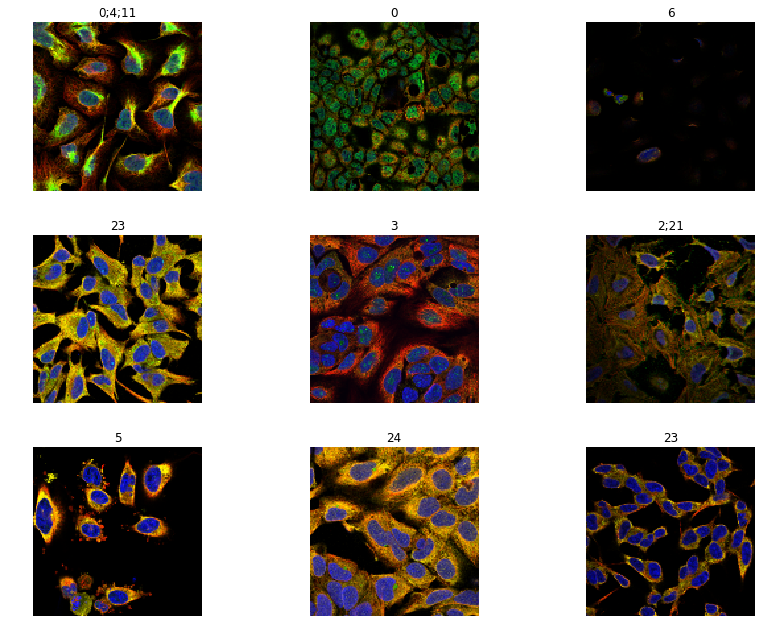

In [17]:
data.show_batch(rows=3, figsize=(12,9))

In [18]:
import fastai.vision
from torchvision.models import densenet201 
def _densenet201_split(m:nn.Module): return (m[0][0][7], m[1]) 
_densenet201_meta  = {'cut':-1, 'split': _densenet201_split} 
fastai.vision.learner.model_meta = { densenet201:{**_densenet201_meta} }
arch = densenet201

In [27]:
f1_score = partial(fbeta, thresh=0.2, beta=2)

You can also use metrics = accuracy_thresh 

In [28]:
learn = create_cnn(data, arch, metrics= [f1_score])

In [32]:
learn.fit(5)

epoch,train_loss,valid_loss,fbeta
1,0.158340,0.151030,0.414334
2,0.150388,0.145125,0.450885
3,0.147297,0.142161,0.467589
4,0.143246,0.139878,0.478876
5,0.141183,0.138224,0.502011


In [33]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-5,3e-4), pct_start=0.05)

epoch,train_loss,valid_loss,fbeta
1,0.136129,0.135291,0.513951
2,0.131597,0.133246,0.517654
3,0.128671,0.132226,0.530226
4,0.126549,0.131463,0.531028
5,0.124972,0.131213,0.532253


Loss is improving, you can add more epochs

In [34]:
preds,_ = learn.get_preds(DatasetType.Test)

In [35]:
pred_labels = [' '.join(list([str(i) for i in np.nonzero(row>0.2)[0]])) for row in np.array(preds)]
df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
df.to_csv('submission2.csv', header=True, index=False)

In [66]:
pred_test_tta,_=learn.TTA(ds_type=DatasetType.Test)

In [67]:
pred_labels2 = [' '.join(list([str(i) for i in np.nonzero(row>0.2)[0]])) for row in np.array(pred_test_tta)]
df2 = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels2})
df2.to_csv('submission5.csv', header=True, index=False)

In [41]:
pred,y=learn.get_preds()

In [53]:
sample_csv = f'sample_submission.csv'

Thresholds from Lafoss https://www.kaggle.com/iafoss/pretrained-resnet34-with-rgby-0-460-public-lb

In [54]:
th_t = np.array([0.565,0.39,0.55,0.345,0.33,0.39,0.33,0.45,0.38,0.39,
               0.34,0.42,0.31,0.38,0.49,0.50,0.38,0.43,0.46,0.40,
               0.39,0.505,0.37,0.47,0.41,0.545,0.32,0.1])

In [55]:
from sklearn.metrics import f1_score as f1_sc

In [56]:
def eval_pred(pred,y):
    ths=np.arange(0.001,1,0.01)
    preds_s=F.sigmoid(pred)
    th_val=ths[np.argmax([f1_sc(y,preds_s>th,average='macro') for th in ths])]
    print('F1 macro: ',f1_sc(to_np(y),to_np(preds_s)>th_t,average='macro'))
    print(f'F1 macro (th = {th_val}): ',f1_sc(to_np(y),to_np(preds_s)>th_val,average='macro'))
    plt.plot(f1_sc(to_np(y),to_np(preds_s)>th_t,average=None),label='opt')
    plt.plot(f1_sc(to_np(y),to_np(preds_s)>th_val,average=None),label='valid')
    plt.legend()

In [57]:
ths=np.arange(0.001,1,0.01)
preds_s=F.sigmoid(pred)
th_val=ths[np.argmax([f1_sc(y,preds_s>th,average='macro') for th in ths])]

F1 macro:  0.12437384576697572
F1 macro (th = 0.5409999999999999):  0.2691606970023197


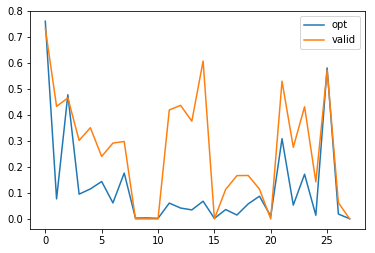

In [58]:
eval_pred(pred,y)

In [63]:
def save_pred(pred, th=0.5, fname='protein_classification.csv'):
    pred_list = []
    for line in pred:
        s = ' '.join(list([str(i) for i in np.nonzero(line>th)[0]]))
        pred_list.append(s)
        
    sample_df = pd.read_csv(sample_csv)
    sample_list = list(sample_df.Id)
    #fnames_=[fname.split('/')[-1] for fname in learn.data.test_ds.fnames]
    pred_dic = dict((key, value) for (key, value) 
                in zip(test_ids,pred_list))
    pred_list_cor = [pred_dic[id] for id in test_ids]
    df = pd.DataFrame({'Id':sample_list,'Predicted':pred_list_cor})
    df.to_csv(fname, header=True, index=False)

In [65]:
save_pred(to_np(F.sigmoid(preds)), th=th_val, fname=f'protein_classification_{np.around(th_val,decimals=2)}.csv')

save_pred(to_np(F.sigmoid(preds)), th=th_t, fname='protein_classification_customth.csv')

In [68]:
save_pred(to_np(F.sigmoid(pred_test_tta)), th=th_val, fname=f'protein_classification_{np.around(th_val,decimals=2)}_tta.csv')

save_pred(to_np(F.sigmoid(pred_test_tta)), th=th_t, fname='protein_classification_customth_tta.csv')

/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1174: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
